# Artificial Neural Networks and Deep Learning

---

## Lecture 5b: Semantic Segmentation with UNet

<img src="https://drive.google.com/uc?export=view&id=1HIFUP4_SABD57IjB2f4DNRekCZlPWi5k" width="500"/>

## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load and Process Data

In [2]:
# Set environment variables for Cityscapes dataset
os.environ["DATASET_NAME"] = "cityscapes_data.zip"
os.environ["DATASET_URL"] = "15IEOX3K-VKVJFLQ9BfN0edxXzTVuwxz1"

# Check if Cityscapes dataset exists, download and unzip if not
if not os.path.exists(os.environ["DATASET_NAME"]):
    print("Downloading Cityscapes dataset...")
    !gdown -q ${DATASET_URL} -O ${DATASET_NAME}
    print("Cityscapes dataset downloaded!")

    print("Unzipping Cityscapes dataset...")
    !unzip -o ${DATASET_NAME}
    print("Cityscapes dataset unzipped!")
else:
    print("Cityscapes dataset already downloaded and unzipped. Using cached data.")

# Set environment variables for Cityscapes labels
os.environ["LABELS_NAME"] = "cityscapes_labels.zip"
os.environ["LABELS_URL"] = "1rgf0ntbqFD6wkIT_P_1okmxxmwYt9lqo"

# Check if Cityscapes labels exist, download and unzip if not
if not os.path.exists(os.environ["LABELS_NAME"]):
    print("Downloading Cityscapes labels...")
    !gdown -q ${LABELS_URL} -O ${LABELS_NAME}
    print("Cityscapes labels downloaded!")

    print("Unzipping Cityscapes labels...")
    !unzip -o ${LABELS_NAME}
    print("Cityscapes labels unzipped!")
else:
    print("Cityscapes labels already downloaded and unzipped. Using cached data.")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/dusseldorf_000131_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000132_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000133_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000134_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000135_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000136_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000137_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000138_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000139_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000140_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000141_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000142_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000143_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000144_000019_leftImg8bit.png  
  inflating: data/dusseldorf_000145_000019_leftImg8bit.png  
  infla

In [3]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

In [4]:
# Load image and label paths
print("Loading file paths...")
image_paths = sorted([os.path.join('data', f) for f in os.listdir('data')])
label_paths = sorted([os.path.join('labels', f) for f in os.listdir('labels')])
print("File paths loaded!")

# Display some examples of paths
print("\nFirst 5 image paths:", image_paths[:5])
print("First 5 label paths:", label_paths[:5])

Loading file paths...
File paths loaded!

First 5 image paths: ['data/aachen_000000_000019_leftImg8bit.png', 'data/aachen_000001_000019_leftImg8bit.png', 'data/aachen_000002_000019_leftImg8bit.png', 'data/aachen_000003_000019_leftImg8bit.png', 'data/aachen_000004_000019_leftImg8bit.png']
First 5 label paths: ['labels/aachen_000000_000019_gtFine_color.png', 'labels/aachen_000001_000019_gtFine_color.png', 'labels/aachen_000002_000019_gtFine_color.png', 'labels/aachen_000003_000019_gtFine_color.png', 'labels/aachen_000004_000019_gtFine_color.png']


In [5]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    image_paths, label_paths, test_size=SPLITS_SIZE, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 2375
Validation: 300
Test: 300


In [6]:
# Define whether to use the simple or detailed version
simple_version = True

# Define the category mapping
if simple_version:
    category_map = {
        0: 0,  # unlabelled
        1: 0,  # static
        2: 0,  # ground
        3: 1,  # road
        4: 1,  # sidewalk
        5: 1,  # parking
        6: 1,  # rail track
        7: 2,  # building
        8: 2,  # wall
        9: 2,  # fence
        10: 2, # guard rail
        11: 2, # bridge
        12: 2, # tunnel
        13: 3, # pole
        15: 3, # traffic light
        16: 3, # traffic sign
        17: 4, # vegetation
        18: 4, # terrain
        19: 5, # sky
        20: 6, # person
        21: 6, # rider
        22: 7, # car
        23: 7, # truck
        24: 7, # bus
        25: 7, # caravan
        26: 7, # trailer
        27: 7, # train
        28: 7, # motorcycle
        29: 7, # bicycle
    }
else:
    category_map = {
        0: 0,  # unlabelled
        1: 1,  # static
        2: 2,  # ground
        3: 3,  # road
        4: 4,  # sidewalk
        5: 5,  # parking
        6: 6,  # rail track
        7: 7,  # building
        8: 8,  # wall
        9: 9,  # fence
        10: 10, # guard rail
        11: 11, # bridge
        12: 12, # tunnel
        13: 13, # pole
        15: 14, # traffic light
        16: 15, # traffic sign
        17: 16, # vegetation
        18: 17, # terrain
        19: 18, # sky
        20: 19, # person
        21: 20, # rider
        22: 21, # car
        23: 22, # truck
        24: 23, # bus
        25: 24, # caravan
        26: 25, # trailer
        27: 26, # train
        28: 27, # motorcycle
        29: 28, # bicycle
    }


# Calculate the correct number of classes after mapping
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 29
Number of classes after mapping: 8


In [7]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)  # Ensure 3 channels
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [8]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [9]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [10]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 3)
Images shape: (64, 64, 128, 3)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


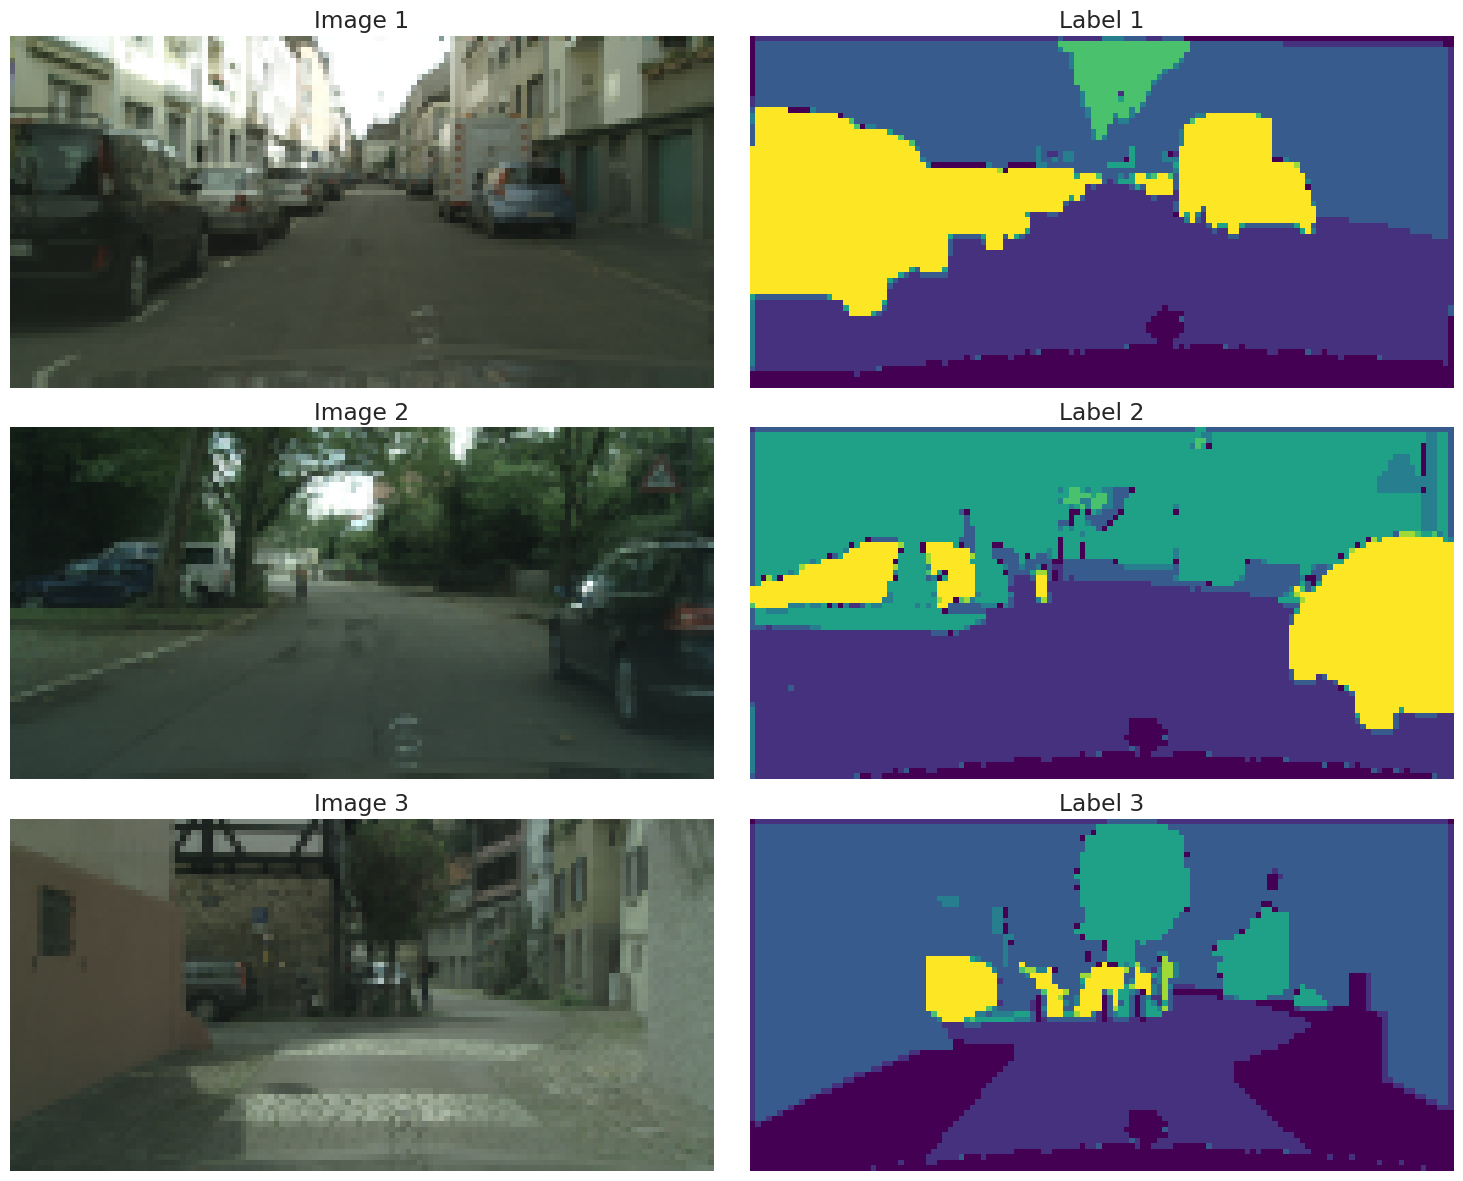

In [12]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

<img src="https://drive.google.com/uc?export=view&id=1MdeusJwgLROcAFeBEcXvmMzGSy4SGxfG" width="900"/>

## 🛠️ Models and Experiments

In [13]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [14]:
def get_unet_model(input_shape=(64, 128, 3), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 3)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          896 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 474,344 (1.81 MB)

 Trainable params: 473,064 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

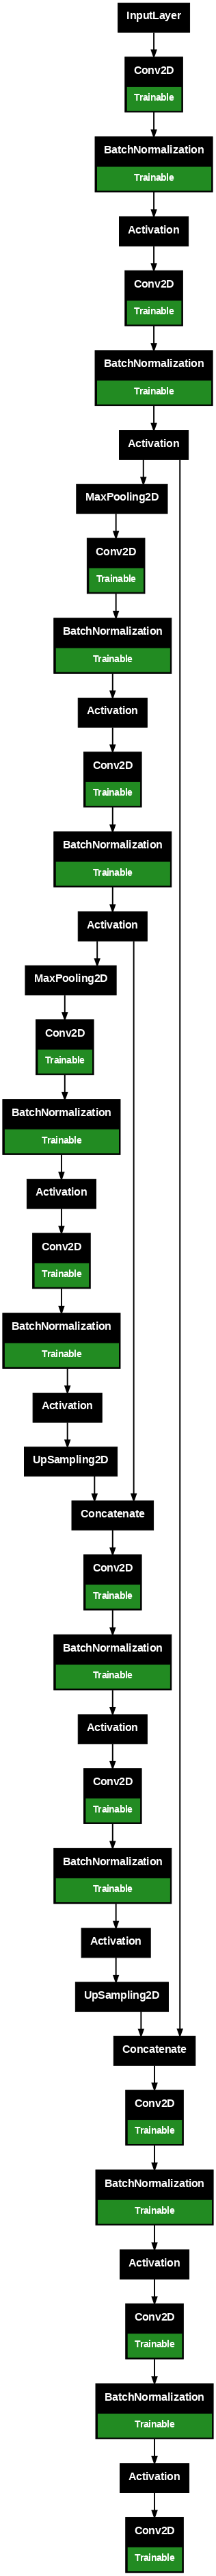

In [15]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [16]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [17]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [18]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(val_img[0], val_lbl[0])

Epoch 1/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.5172 - loss: 1.5249 - mean_iou: 0.2163

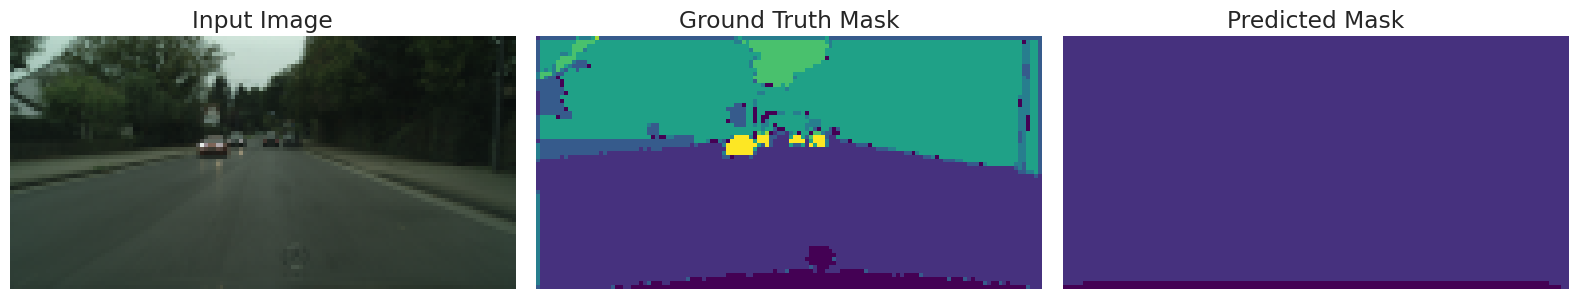

38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5210 - loss: 1.5157 - mean_iou: 0.2184 - val_accuracy: 0.4216 - val_loss: 2.0271 - val_mean_iou: 0.0545
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.7831 - loss: 0.7786 - mean_iou: 0.4239 - val_accuracy: 0.4178 - val_loss: 2.2557 - val_mean_iou: 0.0548
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.8105 - loss: 0.6498 - mean_iou: 0.4542 - val_accuracy: 0.4170 - val_loss: 2.2130 - val_mean_iou: 0.0554
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.8221 - loss: 0.5922 - mean_iou: 0.4681 - val_accuracy: 0.4136 - val_loss: 2.4710 - val_mean_iou: 0.0551
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.8292 - loss: 0.5630 - mean_iou: 0.4944 - val_accuracy: 0.4671 - val_loss: 1.9003 - val_mean_iou: 0.0828
Epoch 6/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8319 - loss: 0.5485 - mean_iou: 0.5080

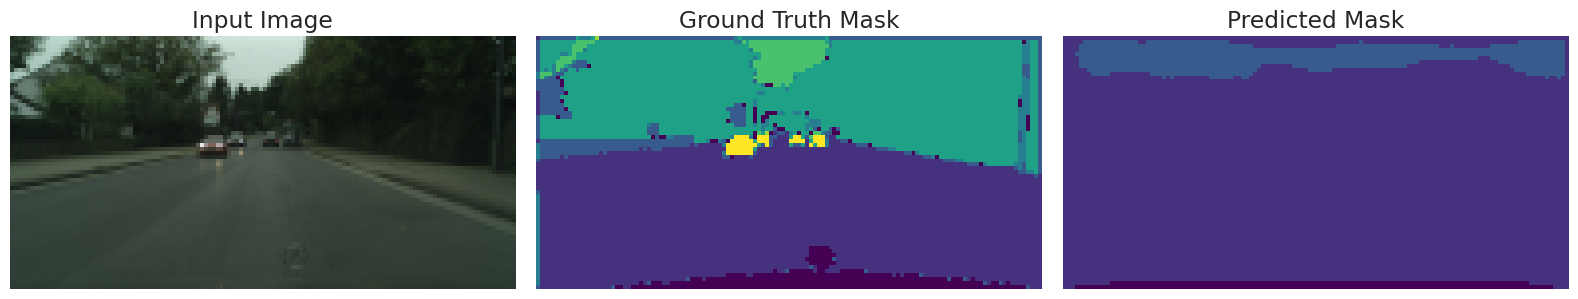

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.8320 - loss: 0.5482 - mean_iou: 0.5083 - val_accuracy: 0.5227 - val_loss: 1.6377 - val_mean_iou: 0.1088
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.8405 - loss: 0.5198 - mean_iou: 0.5204 - val_accuracy: 0.5590 - val_loss: 1.5871 - val_mean_iou: 0.1353
Epoch 8/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.8422 - loss: 0.5072 - mean_iou: 0.5297 - val_accuracy: 0.6110 - val_loss: 1.2582 - val_mean_iou: 0.1632
Epoch 9/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.8460 - loss: 0.4948 - mean_iou: 0.5342 - val_accuracy: 0.6271 - val_loss: 1.2288 - val_mean_iou: 0.2060
Epoch 10/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.8426 - loss: 0.5035 - mean_iou: 0.5327 - val_accuracy: 0.7261 - val_loss: 0.8457 - val_mean_iou: 0.3304
Epoch 11/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8483 - loss: 0.4841 - mean_iou: 0.5454

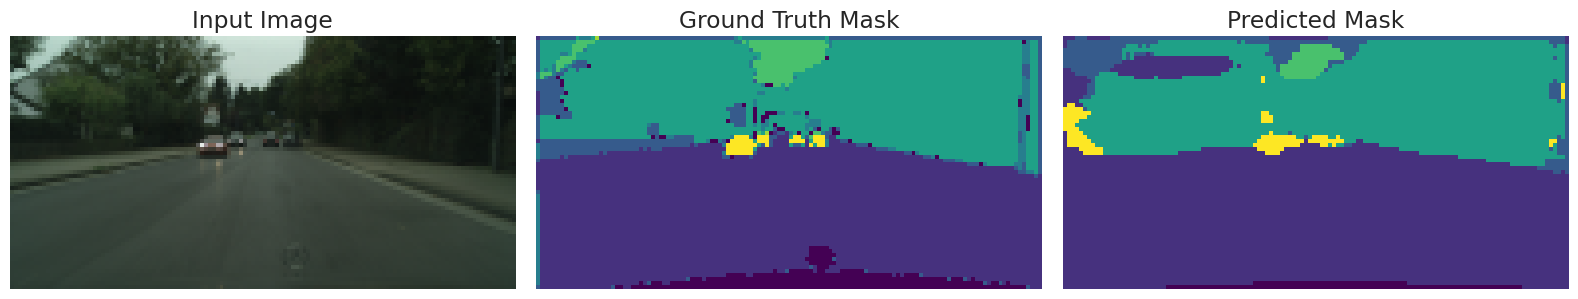

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.8483 - loss: 0.4840 - mean_iou: 0.5456 - val_accuracy: 0.7567 - val_loss: 0.7490 - val_mean_iou: 0.3685
Epoch 12/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.8517 - loss: 0.4739 - mean_iou: 0.5505 - val_accuracy: 0.7915 - val_loss: 0.6586 - val_mean_iou: 0.4487
Epoch 13/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.8552 - loss: 0.4645 - mean_iou: 0.5546 - val_accuracy: 0.8101 - val_loss: 0.6075 - val_mean_iou: 0.4788
Epoch 14/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.8564 - loss: 0.4592 - mean_iou: 0.5570 - val_accuracy: 0.8199 - val_loss: 0.5595 - val_mean_iou: 0.4887
Epoch 15/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.8550 - loss: 0.4586 - mean_iou: 0.5552 - val_accuracy: 0.8344 - val_loss: 0.5261 - val_mean_iou: 0.5246
Epoch 16/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8602 - loss: 0.4443 - mean_iou: 0.5663

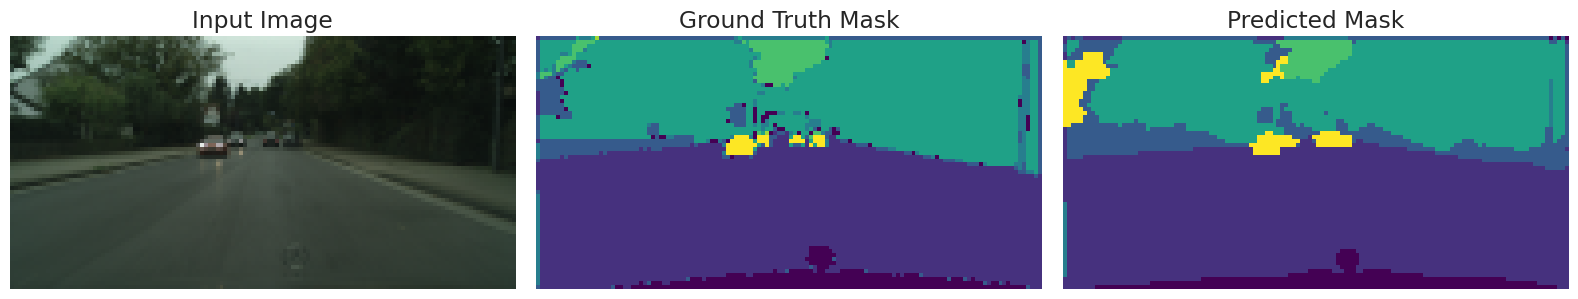

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.8601 - loss: 0.4443 - mean_iou: 0.5664 - val_accuracy: 0.8364 - val_loss: 0.5181 - val_mean_iou: 0.5117
Epoch 17/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.8555 - loss: 0.4645 - mean_iou: 0.5605 - val_accuracy: 0.8364 - val_loss: 0.5167 - val_mean_iou: 0.5258
Epoch 18/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.8631 - loss: 0.4341 - mean_iou: 0.5704 - val_accuracy: 0.8305 - val_loss: 0.5261 - val_mean_iou: 0.5186
Epoch 19/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.8631 - loss: 0.4366 - mean_iou: 0.5724 - val_accuracy: 0.8482 - val_loss: 0.4778 - val_mean_iou: 0.5488
Epoch 20/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.8644 - loss: 0.4300 - mean_iou: 0.5777 - val_accuracy: 0.8331 - val_loss: 0.5449 - val_mean_iou: 0.4727
Epoch 21/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8648 - loss: 0.4262 - mean_iou: 0.5732

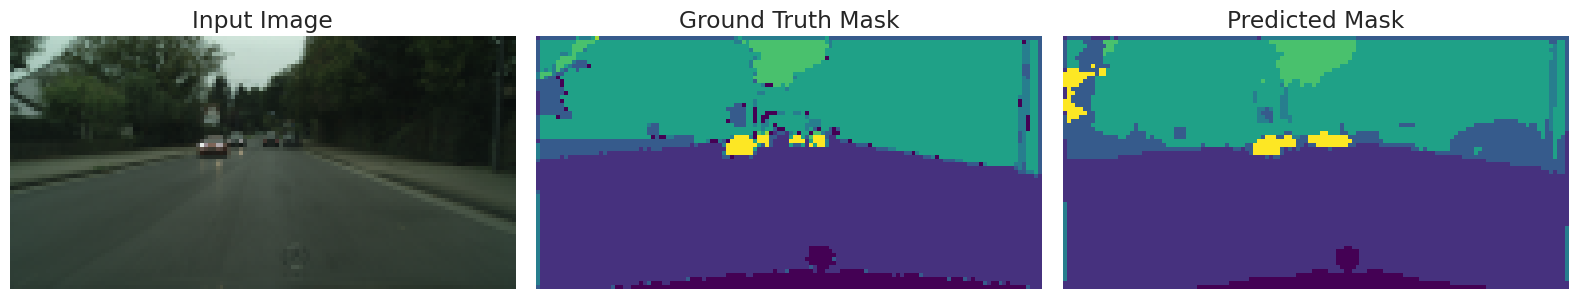

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.8649 - loss: 0.4260 - mean_iou: 0.5735 - val_accuracy: 0.8460 - val_loss: 0.4842 - val_mean_iou: 0.5502
Epoch 22/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.8676 - loss: 0.4171 - mean_iou: 0.5819 - val_accuracy: 0.8262 - val_loss: 0.5423 - val_mean_iou: 0.5302
Epoch 23/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.8651 - loss: 0.4303 - mean_iou: 0.5777 - val_accuracy: 0.8378 - val_loss: 0.5125 - val_mean_iou: 0.5340
Epoch 24/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.8683 - loss: 0.4136 - mean_iou: 0.5817 - val_accuracy: 0.8172 - val_loss: 0.5680 - val_mean_iou: 0.5303
Epoch 25/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.8677 - loss: 0.4134 - mean_iou: 0.5834 - val_accuracy: 0.8397 - val_loss: 0.5017 - val_mean_iou: 0.5467
Epoch 26/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8696 - loss: 0.4083 - mean_iou: 0.5842

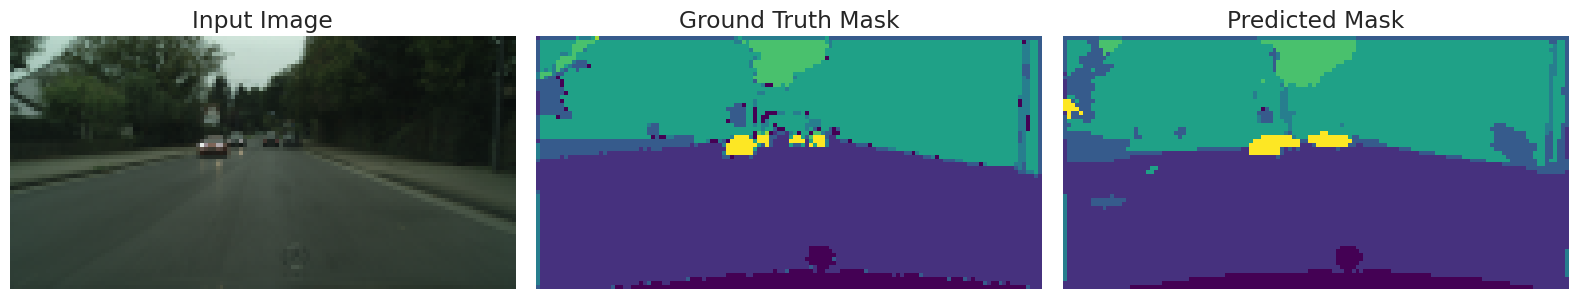

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.8696 - loss: 0.4082 - mean_iou: 0.5844 - val_accuracy: 0.8540 - val_loss: 0.4581 - val_mean_iou: 0.5719
Epoch 27/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.8716 - loss: 0.4012 - mean_iou: 0.5882 - val_accuracy: 0.8570 - val_loss: 0.4520 - val_mean_iou: 0.5648
Epoch 28/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8726 - loss: 0.3999 - mean_iou: 0.5894 - val_accuracy: 0.8618 - val_loss: 0.4427 - val_mean_iou: 0.5692
Epoch 29/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.8732 - loss: 0.3966 - mean_iou: 0.5906 - val_accuracy: 0.8560 - val_loss: 0.4518 - val_mean_iou: 0.5779
Epoch 30/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.8723 - loss: 0.3983 - mean_iou: 0.5912 - val_accuracy: 0.8550 - val_loss: 0.4555 - val_mean_iou: 0.5553
Epoch 31/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8763 - loss: 0.3868 - mean_iou: 0.5971

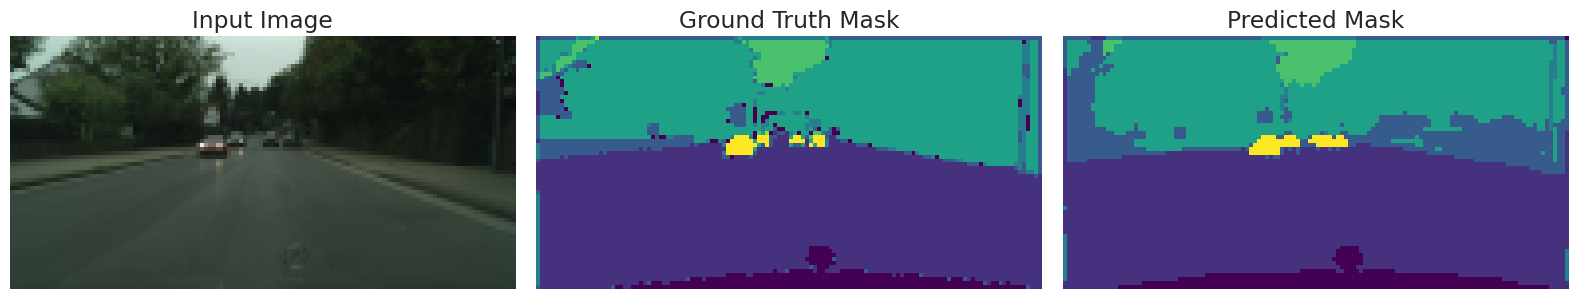

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.8762 - loss: 0.3869 - mean_iou: 0.5972 - val_accuracy: 0.8529 - val_loss: 0.4703 - val_mean_iou: 0.5569
Epoch 32/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.8757 - loss: 0.3872 - mean_iou: 0.5973 - val_accuracy: 0.8302 - val_loss: 0.5236 - val_mean_iou: 0.5245
Epoch 33/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.8689 - loss: 0.4051 - mean_iou: 0.5910 - val_accuracy: 0.8585 - val_loss: 0.4538 - val_mean_iou: 0.5538
Epoch 34/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.8762 - loss: 0.3862 - mean_iou: 0.6006 - val_accuracy: 0.8637 - val_loss: 0.4294 - val_mean_iou: 0.5784
Epoch 35/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8787 - loss: 0.3768 - mean_iou: 0.6022 - val_accuracy: 0.8558 - val_loss: 0.4533 - val_mean_iou: 0.5705
Epoch 36/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8799 - loss: 0.3746 - mean_iou: 0.6058

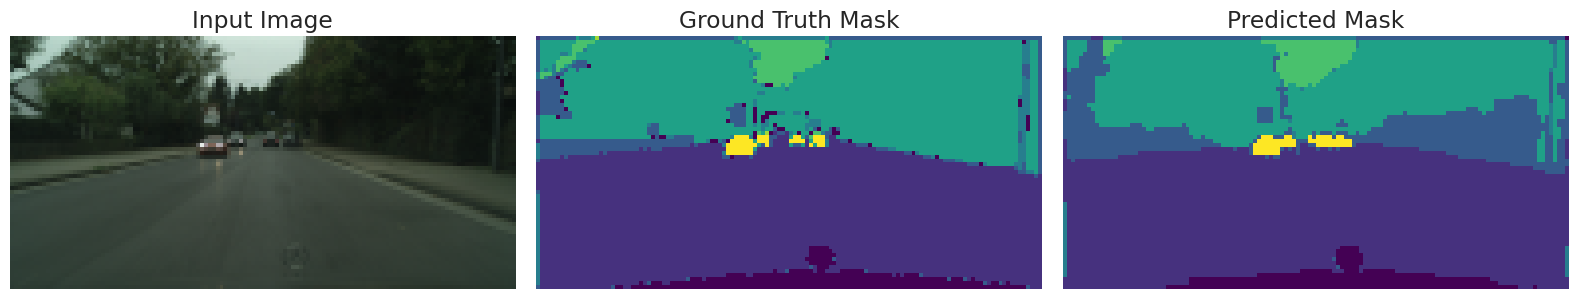

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.8798 - loss: 0.3747 - mean_iou: 0.6058 - val_accuracy: 0.8481 - val_loss: 0.4730 - val_mean_iou: 0.5625
Epoch 37/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.8799 - loss: 0.3717 - mean_iou: 0.6073 - val_accuracy: 0.8436 - val_loss: 0.4990 - val_mean_iou: 0.5412
Epoch 38/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.8793 - loss: 0.3737 - mean_iou: 0.6039 - val_accuracy: 0.8056 - val_loss: 0.6095 - val_mean_iou: 0.4922
Epoch 39/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.8673 - loss: 0.4128 - mean_iou: 0.5857 - val_accuracy: 0.8501 - val_loss: 0.4871 - val_mean_iou: 0.5703
Epoch 40/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.8797 - loss: 0.3729 - mean_iou: 0.6056 - val_accuracy: 0.8497 - val_loss: 0.4858 - val_mean_iou: 0.5586
Epoch 41/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8765 - loss: 0.3788 - mean_iou: 0.6029

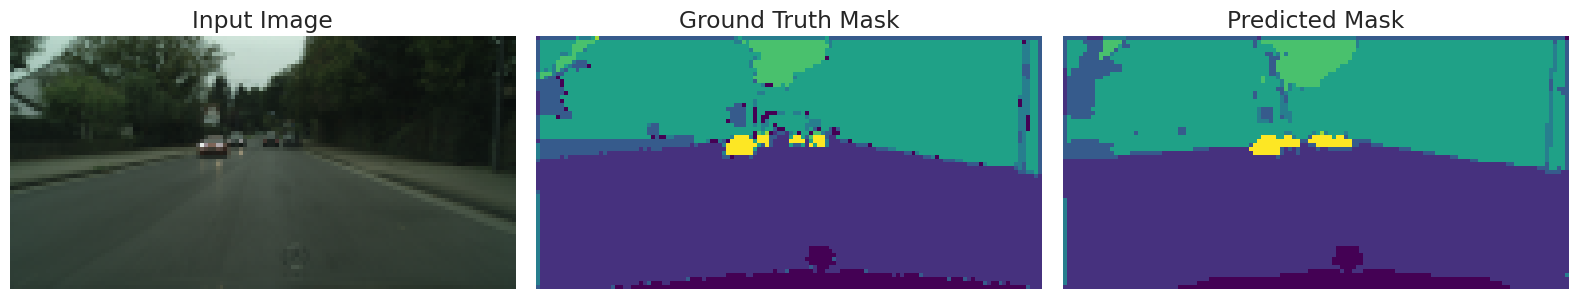

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.8766 - loss: 0.3785 - mean_iou: 0.6031 - val_accuracy: 0.8636 - val_loss: 0.4361 - val_mean_iou: 0.5816
Epoch 42/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.8812 - loss: 0.3671 - mean_iou: 0.6084 - val_accuracy: 0.8596 - val_loss: 0.4430 - val_mean_iou: 0.5744
Epoch 43/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8759 - loss: 0.3787 - mean_iou: 0.6052 - val_accuracy: 0.8360 - val_loss: 0.5253 - val_mean_iou: 0.5297
Epoch 44/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.8824 - loss: 0.3628 - mean_iou: 0.6096 - val_accuracy: 0.8228 - val_loss: 0.5694 - val_mean_iou: 0.5284
Epoch 45/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.8832 - loss: 0.3605 - mean_iou: 0.6098 - val_accuracy: 0.8405 - val_loss: 0.5016 - val_mean_iou: 0.5603
Epoch 46/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8809 - loss: 0.3668 - mean_iou: 0.6064

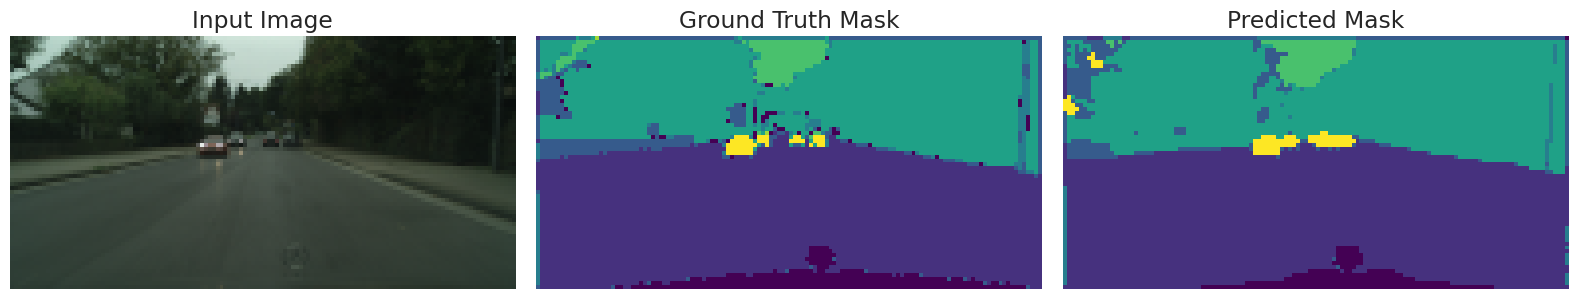

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.8810 - loss: 0.3666 - mean_iou: 0.6066 - val_accuracy: 0.8507 - val_loss: 0.4695 - val_mean_iou: 0.5703
Epoch 47/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.8787 - loss: 0.3712 - mean_iou: 0.6080 - val_accuracy: 0.8419 - val_loss: 0.5126 - val_mean_iou: 0.5638
Epoch 48/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.8829 - loss: 0.3607 - mean_iou: 0.6114 - val_accuracy: 0.8431 - val_loss: 0.5124 - val_mean_iou: 0.5622
Epoch 49/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.8861 - loss: 0.3507 - mean_iou: 0.6137 - val_accuracy: 0.8486 - val_loss: 0.4748 - val_mean_iou: 0.5660
Epoch 50/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.8864 - loss: 0.3491 - mean_iou: 0.6158 - val_accuracy: 0.8321 - val_loss: 0.5320 - val_mean_iou: 0.5495
Epoch 51/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8824 - loss: 0.3597 - mean_iou: 0.6111

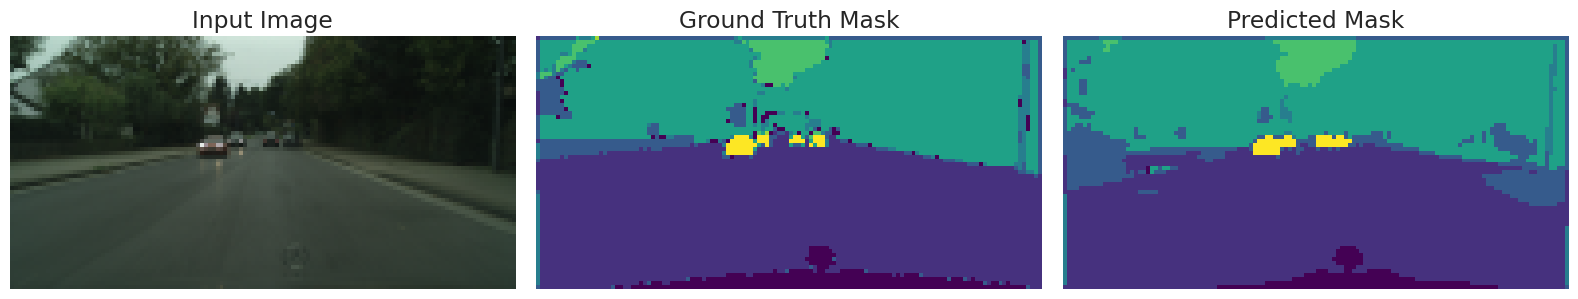

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.8825 - loss: 0.3595 - mean_iou: 0.6113 - val_accuracy: 0.8248 - val_loss: 0.5470 - val_mean_iou: 0.5518
Epoch 52/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.8833 - loss: 0.3577 - mean_iou: 0.6115 - val_accuracy: 0.8427 - val_loss: 0.4913 - val_mean_iou: 0.5729
Epoch 53/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.8871 - loss: 0.3465 - mean_iou: 0.6168 - val_accuracy: 0.8621 - val_loss: 0.4400 - val_mean_iou: 0.5779
Epoch 54/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8895 - loss: 0.3400 - mean_iou: 0.6191 - val_accuracy: 0.8521 - val_loss: 0.4927 - val_mean_iou: 0.5662
Epoch 55/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.8851 - loss: 0.3517 - mean_iou: 0.6151 - val_accuracy: 0.8144 - val_loss: 0.5891 - val_mean_iou: 0.5410
Epoch 56/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8894 - loss: 0.3390 - mean_iou: 0.6196

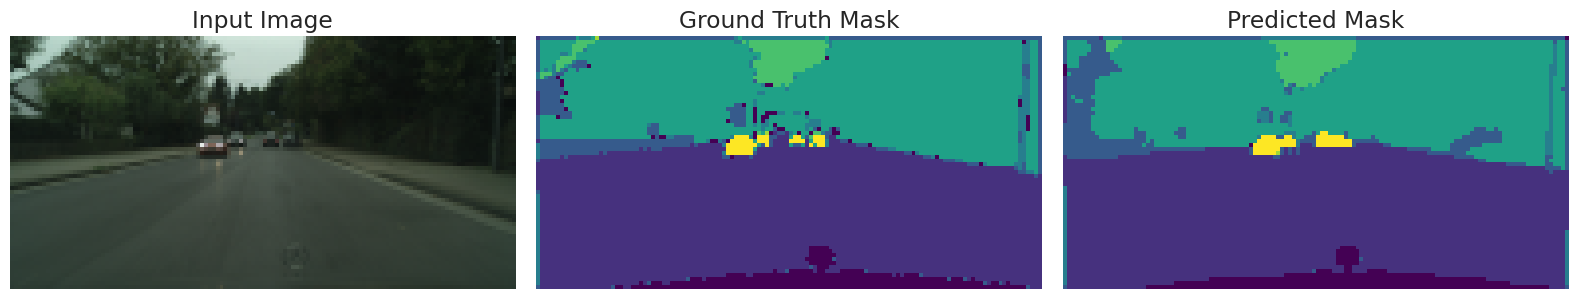

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8894 - loss: 0.3390 - mean_iou: 0.6197 - val_accuracy: 0.8562 - val_loss: 0.4551 - val_mean_iou: 0.5756
Epoch 57/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.8853 - loss: 0.3501 - mean_iou: 0.6151 - val_accuracy: 0.8620 - val_loss: 0.4395 - val_mean_iou: 0.5889
Epoch 58/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8907 - loss: 0.3354 - mean_iou: 0.6231 - val_accuracy: 0.8603 - val_loss: 0.4525 - val_mean_iou: 0.5678
Epoch 59/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.8899 - loss: 0.3383 - mean_iou: 0.6193 - val_accuracy: 0.8510 - val_loss: 0.4622 - val_mean_iou: 0.5760
Epoch 60/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.8896 - loss: 0.3372 - mean_iou: 0.6214 - val_accuracy: 0.8164 - val_loss: 0.6072 - val_mean_iou: 0.5238
Epoch 61/1000
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8705 - loss: 0.3966 - mean_iou: 0.5937

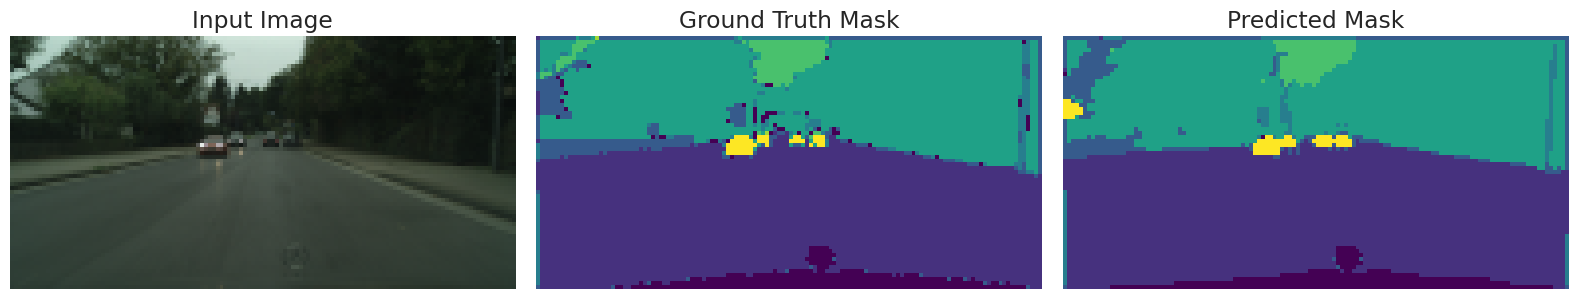

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.8707 - loss: 0.3959 - mean_iou: 0.5942 - val_accuracy: 0.8611 - val_loss: 0.4424 - val_mean_iou: 0.5842
Epoch 62/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.8887 - loss: 0.3409 - mean_iou: 0.6181 - val_accuracy: 0.8532 - val_loss: 0.4696 - val_mean_iou: 0.5596
Epoch 63/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.8886 - loss: 0.3408 - mean_iou: 0.6207 - val_accuracy: 0.8545 - val_loss: 0.4756 - val_mean_iou: 0.5605
Epoch 64/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.8926 - loss: 0.3290 - mean_iou: 0.6250 - val_accuracy: 0.8555 - val_loss: 0.4794 - val_mean_iou: 0.5646
Final validation Mean Intersection Over Union: 58.89%


In [19]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

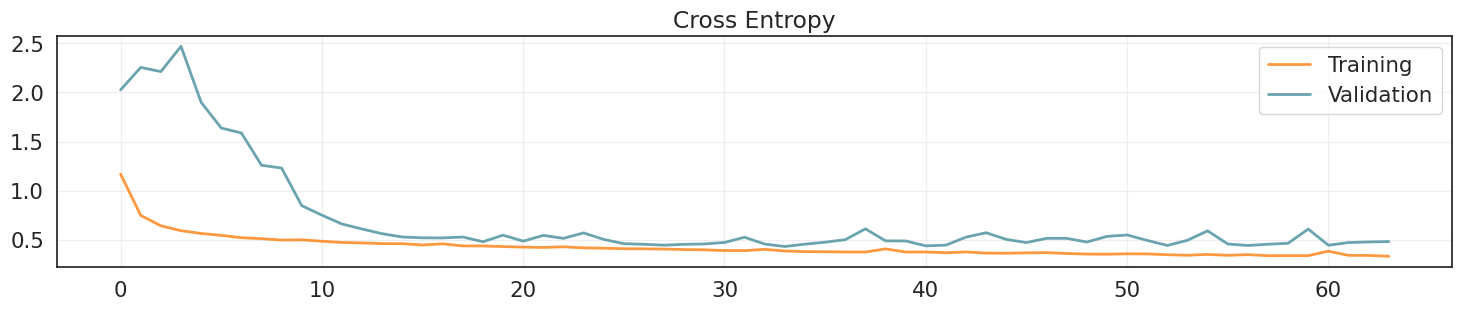

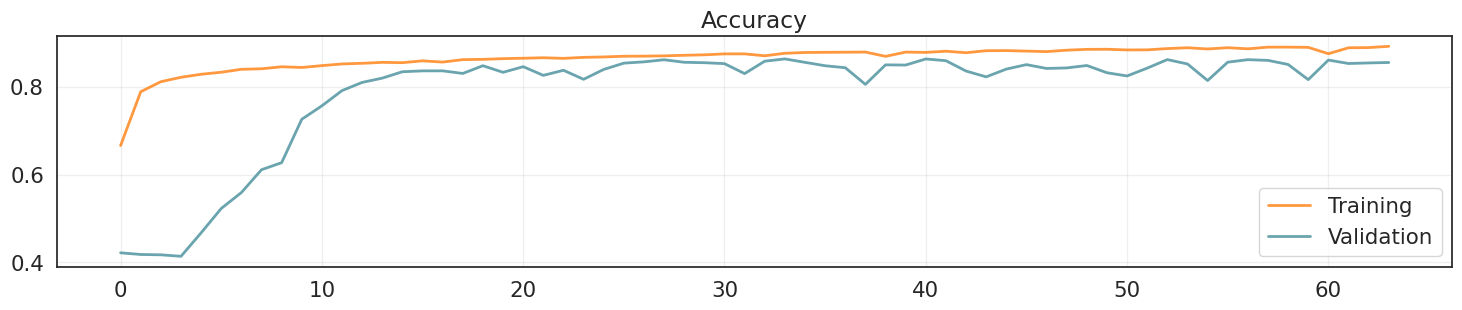

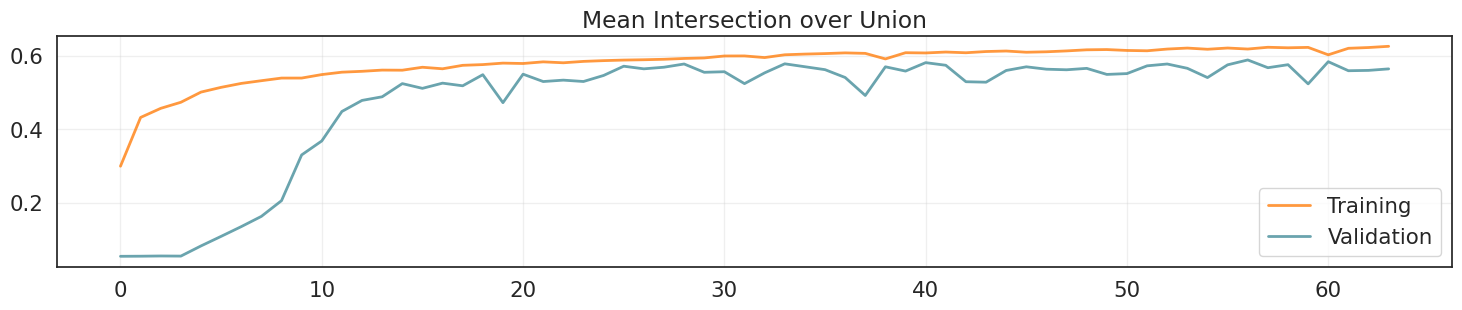

In [20]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 3)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          896 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 474,344 (1.81 MB)

 Trainable params: 473,064 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

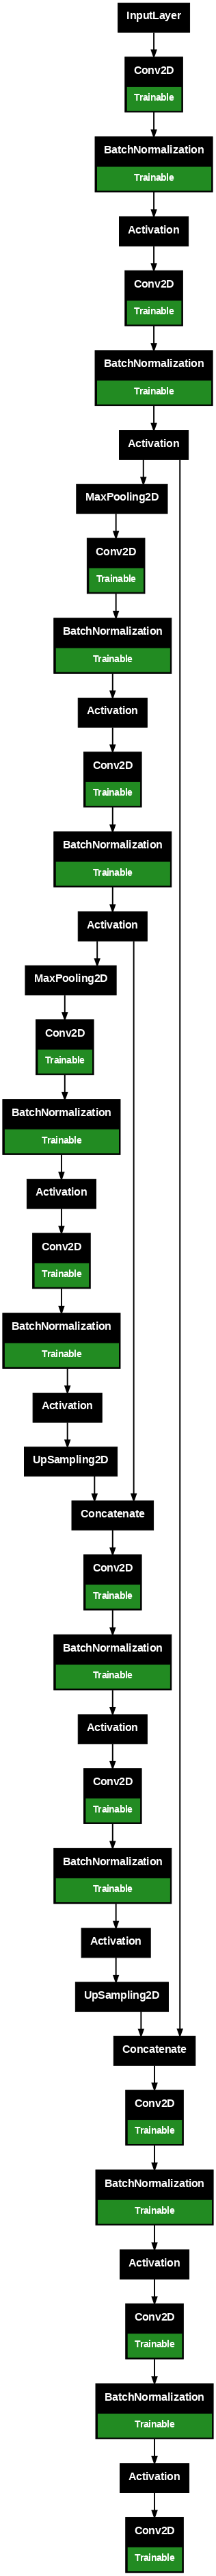

In [22]:
# Load UNet model without compiling
model = tfk.models.load_model('UNet_58.89.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [23]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.8646
Test Mean Intersection over Union: 0.5786


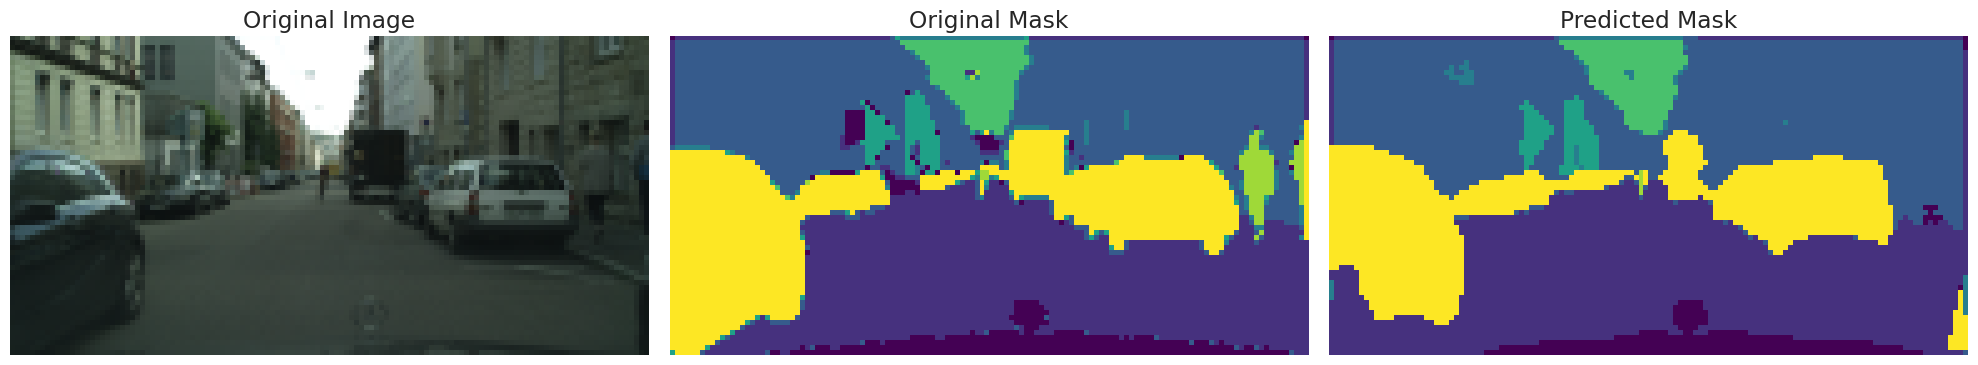

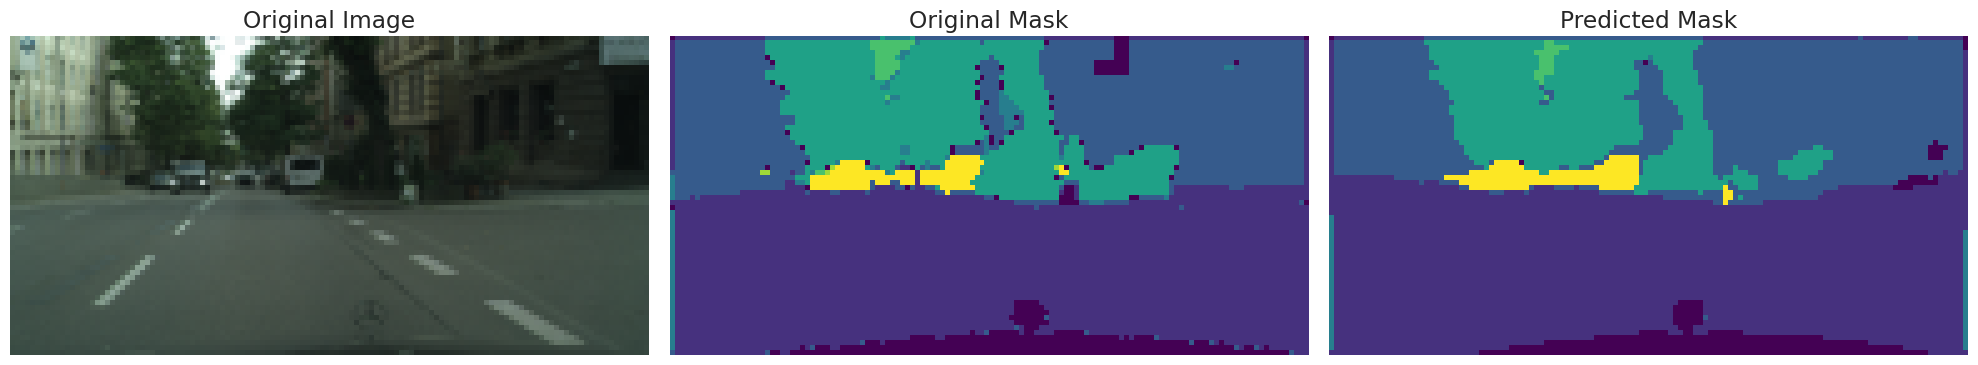

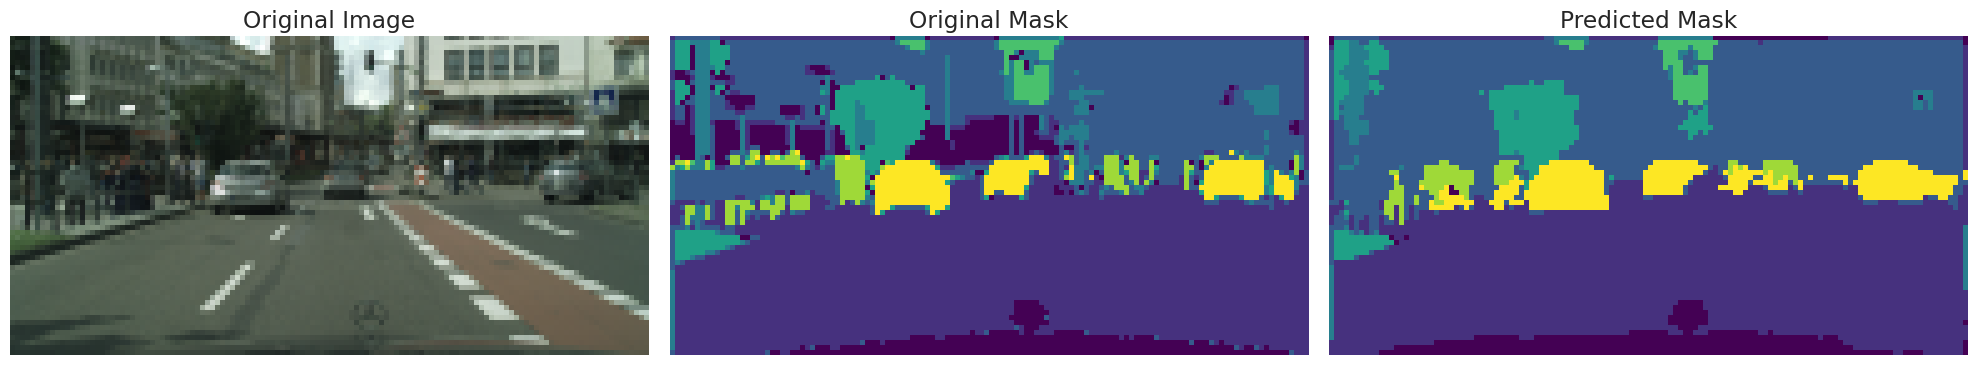

In [24]:
def plot_triptychs(dataset, model, num_samples=1):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    """
    # Take samples from the dataset
    samples = dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create colormap based on number of classes in labels
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0])
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        colored_label = apply_colormap(labels[0], colormap)
        axes[1].imshow(colored_label)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        colored_pred = apply_colormap(pred[0], colormap)
        axes[2].imshow(colored_pred)
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()

# Example usage:
# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)